## ESA CCI v4 Access and Visualize

Authors: Emile Tenezakis (DevSeed), Rajat Shinde (UAH)

Date: September 12, 2023

Description: In this tutorial, we explore accessing and visualizing ESA CCI Version 4 data from the MAAP STAC catalog. We make use of the [stackstac package](https://github.com/gjoseph92/stackstac) that allows us to turn a stack collection imported from the catalog with the [`pystac_client`](https://pystac-client.readthedocs.io/en/stable/) to an xarray dataset, and we plot the time series of the mean aboveground biomass for a selected tile of the dataset across the available temporal range.

### Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors. 

### About The Dataset
This dataset comprises estimates of forest Above-Ground Biomass (AGB) for the years 2017, 2018, 2019 and 2020, version 4. They are derived from a combination of Earth Observation (EO) data, depending on the year, from the Copernicus Sentinel-1 mission, Envisat’s ASAR instrument and JAXA’s Advanced Land Observing Satellite (ALOS-1 and ALOS-2), along with additional information from Earth observation sources. The data has been produced as part of the European Space Agency's (ESA's) Climate Change Initiative (CCI) programme by the Biomass CCI team.

### Additional Resources
* [ESA’s Climate Change Initiative Biomass project](https://climate.esa.int/en/odp/#/project/biomass)
* [xarray Documentation](https://docs.xarray.dev/en/stable/index.html)
 

### Importing and Installing Packages
First off, we will install and import the required Python packages if they are not already installed in the workspace.

In [1]:
# !mamba install -y -c conda-forge stackstac
# !pip install pystac_client

In [2]:
from stackstac import stack, mosaic
import pystac_client

### Accessing and Filtering the Items

After installing the require packages, we create a client to access the STAC test catalog.

In [3]:
URL = "https://stac.maap-project.org"
catalog = pystac_client.Client.open(URL)

### Creating an AOI

Now, we define a bounding box of interest to find the tile that covers a small region around Manaus, Brazil (Amazon rainforest).

In [4]:
# BBox for filtering the items in the collection
bbox = [-55,-6,-54.8,-5.8]

We proceed to an item search in the catalog using the `pystac-client`, filtering items covering our area of interest.

In [5]:
stac_collection = catalog.search(
    collections=["ESACCI_Biomass_L4_AGB_V4_100m"],
    bbox=bbox
)

Let's take a quick look at the results of the search. We can access the link of the location where the data is stored using `href` attribute as shown below.

In [6]:
stac_collection.get_all_items()[0].assets['estimates'].href

/opt/conda/lib/python3.10/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


's3://nasa-maap-data-store/file-staging/nasa-map/ESACCI_Biomass_L4_AGB_V4_100m_2020/N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv4.0.tif'

We turn the resulting set of items (we expect one item here in the result, given the size of our bounding box) into an xarray DataArray using `stackstac`.

In [7]:
#Creating a stack of the filtered items
arr = stack(stac_collection.get_all_items())

/opt/conda/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


We can see that our array has the following dimensions : `time` (we have four data points, one for each year - 2017, 2018, 2019 and 2020), `latitude`, `longitude` and `band` (we have two bands : `estimates` with the AGB estimate values, and `std_dev` storing the AGB standard deviation values).

In [8]:
arr

<xarray.DataArray 'stackstac-5517ee4c53a7b2c13f76bf727c00d1fc' (time: 4,
                                                                band: 2,
                                                                y: 11250,
                                                                x: 11251)>
dask.array<fetch_raster_window, shape=(4, 2, 11250, 11251), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time            (time) datetime64[ns] 2017-01-01 2018-01-01 ... 2020-01-01
    id              (time) <U52 'N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-20...
  * band            (band) <U18 'estimates' 'standard_deviation'
  * x               (x) float64 -60.0 -60.0 -60.0 -60.0 ... -50.0 -50.0 -50.0
  * y               (y) float64 0.0 -0.0008889 -0.001778 ... -9.998 -9.999
    proj:epsg       int64 4326
    ...              ...
    proj:transform  object {0.0, 1.0, -60.0, -0.00088888888888, 0.00088888888...
    proj:shape      object {11250}
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-60.0, -9.99...
    title           (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    description     (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-60.00088888828888, -9.9999999...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-60.00|\n| 0.00,-0.00, 0.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00088888888888

Now, we will perform a spatial sub-setting operation to select a subset of the created stack based on the user input for running our experiments. 

In [9]:
min_x = -55
max_y = -5.8
max_x = -54.8 
min_y = -6.0

arr_sub = arr.sel(x=slice(min_x, max_x), y=slice(max_y, min_y))
arr_sub

<xarray.DataArray 'stackstac-5517ee4c53a7b2c13f76bf727c00d1fc' (time: 4,
                                                                band: 2,
                                                                y: 225, x: 225)>
dask.array<getitem, shape=(4, 2, 225, 225), dtype=float64, chunksize=(1, 1, 225, 225), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time            (time) datetime64[ns] 2017-01-01 2018-01-01 ... 2020-01-01
    id              (time) <U52 'N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-20...
  * band            (band) <U18 'estimates' 'standard_deviation'
  * x               (x) float64 -55.0 -55.0 -55.0 -55.0 ... -54.8 -54.8 -54.8
  * y               (y) float64 -5.801 -5.802 -5.803 ... -5.998 -5.999 -6.0
    proj:epsg       int64 4326
    ...              ...
    proj:transform  object {0.0, 1.0, -60.0, -0.00088888888888, 0.00088888888...
    proj:shape      object {11250}
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-60.0, -9.99...
    title           (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    description     (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-60.00088888828888, -9.9999999...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-60.00|\n| 0.00,-0.00, 0.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00088888888888

### Accessing the Subset for further Processing

As it is evident from the above output that the size of the subset xarray has reduced significantly and it can be used further for our analysis. In this tutorial, we are going to perform following two operations:

1. Masking some values based on a condition
2. Plotting Mean time-series for the AGB estimates

#### Masking Values Based on a Condition

Below, we will explore how to mask few values based on a condition and plot the time series for the filtered array.

In [10]:
arr_est = arr_sub.sel(band='estimates')

Now, we are going to filter the values which are less than 10 (and keep values greater than 10) using the [DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html) function. The `.where(<cond>, <True directive>, <False directive>)` function checks a condition and performs specific directives if the condition results in `True` or `False`. In the resulting xarray, all the values less than 10 are going to be `nan` (the default value used if the filtering condition is `True`). We can also replace `nan` by any other value by mentioning it in the `<True directive>`.

In [11]:
arr_masked_lt = arr_est.where(arr_est >= 10)
arr_masked_lt.values

array([[[222., 132., 193., ..., 360., 246., 271.],
        [153., 113., 152., ..., 331., 180., 261.],
        [189., 112., 173., ..., 381., 269., 260.],
        ...,
        [231., 193., 310., ..., 145., 392., 392.],
        [333., 255., 297., ..., 133., 392., 348.],
        [370., 189., 266., ..., 251., 293., 338.]],

       [[219., 100., 138., ..., 363., 271., 198.],
        [188., 114., 101., ..., 345., 198., 254.],
        [142., 144., 179., ..., 325., 306., 372.],
        ...,
        [353., 302., 379., ..., 162., 385., 385.],
        [332., 348., 321., ..., 151., 385., 314.],
        [375., 243., 283., ..., 201., 336., 342.]],

       [[271., 255., 219., ..., 363., 278., 286.],
        [253., 321., 116., ..., 226., 333., 233.],
        [222., 277., 176., ..., 169., 355., 190.],
        ...,
        [304., 336., 275., ..., 318., 308., 234.],
        [340., 234., 348., ..., 315., 356., 330.],
        [243., 323., 264., ..., 288., 307., 318.]],

       [[157., 217., 171., ..., 206.,

Similarly, we could also show filtering values greater than 10 (and keeping values less than 10) based on above approach and updating the condition to `arr_masked_lt = arr_est.where(arr_est <= 10)`.

#### Plotting Mean Time-Series for the AGB Estimates

Below we plot the mean time-series of the masked array.

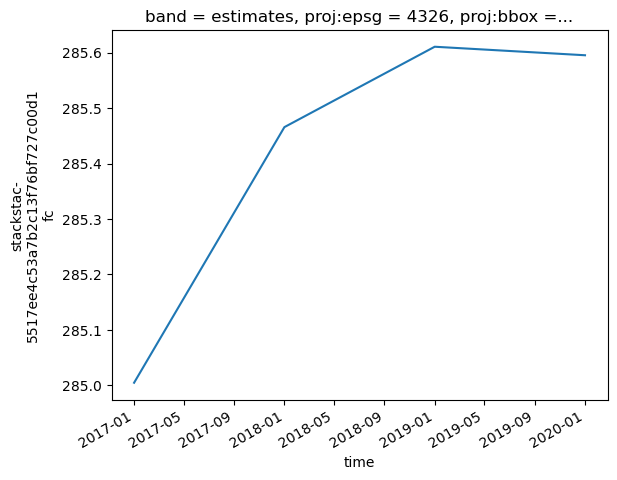

In [12]:
arr_masked_lt.mean(['x','y']).plot()